In [104]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="USDT_BTC",
                  start=string2ts("2017-08-01 00:00:00"),
                  end=string2ts("2018-04-01 00:00:00"),
                  period=3600/4)


per = 0.85
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
 

df["ho"] = df["high"]-df["open"]
df["lo"] = df["low"]-df["open"]

df["outcome"] = (df["close"]>df["open"])*2-1

ts_1 = df.shift(1)
ts_2 = df.shift(2)

df["feat1"] = df["close"] > ts_1["close"]
df["feat2"] = df["close"] > ts_2["close"]

df["gain"] = df["close"] - df["open"]
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage,volatility,ho,lo,outcome,feat1,feat2,gain
date,,,,,,,,,,,,,,
2017-08-01 00:00:00,2888.0000,2890.0000,2876.000000,2880.500001,67.65934198,1.950469e+05,2882.778045,True,9.499999,-4.500001e+00,1,False,False,7.499999
2017-08-01 00:15:00,2925.0000,2925.2000,2888.000000,2888.000000,372.40501745,1.083338e+06,2909.031748,True,37.200000,-1.999979e-08,1,True,False,37.000000
2017-08-01 00:30:00,2901.8584,2927.0000,2900.343313,2925.000000,224.78663809,6.545068e+05,2911.680080,True,2.000000,-2.465669e+01,-1,False,True,-23.141600
2017-08-01 00:45:00,2902.0000,2917.3635,2896.117721,2900.648928,125.93234992,3.661197e+05,2907.272843,False,16.714572,-4.531207e+00,1,True,False,1.351072
2017-08-01 01:00:00,2899.0000,2916.4040,2890.257700,2906.000000,106.67322371,3.096205e+05,2902.513384,False,10.404000,-1.574230e+01,-1,False,False,-7.000000


In [105]:
from stockstats import StockDataFrame
from profit import profit
from mldata import ml_data
from orders import orders

stock = StockDataFrame.retype(df.copy())



df["ml_data"] = ml_data(df["close"],la=10,pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"], "log_return":marketReturn(df["close"]), "feat1":df["feat1"], "feat2":df["feat2"], 
                          "ideal_w2":df["outcome"], "gain":df["gain"], "lo":df["lo"]})


data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

fe2 = ["feat1", "feat2", "gain"]
features = ["feat1", "feat2"]

train2, test2 = df[1:int(len(data)*per)], df[int(len(data)*per):]

X_train, y_train, X_test, y_test = train[features], train["ideal_w2"], test[features], test["ideal_w2"]
X_train2, X_test2 = train[fe2], test[fe2]

Retorno de estrategia ideal: 102929441196.0


In [106]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf = XGBClassifier(n_estimators=9, learning_rate=0.75, gamma=12)

# solo cogiendo feat1 y feat2, no cogiendo gain
clf.fit(X_train, y_train)

pre_proba = clf.predict_proba(X_test)

pre = clf.predict(X_test)

accuracy_score(test2["outcome"], pre)

0.94828571428571429

In [107]:
def trade_with_stop(bar, fee = 0, stop=None):
    """
    Given a bar, with a gain obtained by the closing price - opening price
    it applies a stop limit order to limit a negative loss
    If stop is equal to None, then it returns bar['gain']
    """
    bar['gain'] = bar['gain']*(1-2*fee)
    if stop<>None:
        real_stop = stop*(1-fee)
        if bar['lo']<=stop:
            return real_stop
    # stop == None    
    return bar['gain']

In [115]:
STOP = None
threshold = 0.5
FEE = 0.0015

w = pd.DataFrame(data={"pre":pre ,"close":test["close"], "w_prob":pre_proba[:,1], "outcome":test2["outcome"]})

trades = test[w["pre"]==1][["gain", "close", "lo"]]
trades["pnl"] = trades.apply(lambda x: trade_with_stop(x, FEE, STOP), axis=1)
pnl = test[w["pre"]==1]["gain"]

print pnl.cumsum()[-1]/w["close"][0]*100
print "Con FEE:", trades["pnl"].cumsum()[-1]/w["close"][0]*100
print "Número de de trades:", len(pnl)

609.988248644
Con FEE: 608.158283898
Número de de trades: 1758


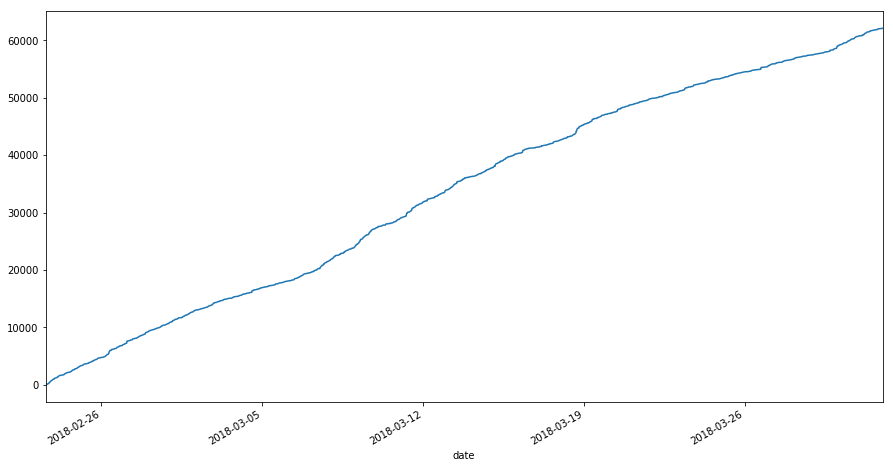

In [109]:
pnl.cumsum().plot()

In [110]:
pnl.cumsum()[-1]

62108.510608200093

In [111]:
w.head(25)

,close,outcome,pre,w_prob
date,,,,
2018-02-23 13:15:00,10181.919200,-1,-1,0.068969
2018-02-23 13:30:00,10130.000000,-1,-1,0.025537
2018-02-23 13:45:00,10181.000000,1,1,0.905350
2018-02-23 14:00:00,10132.999392,-1,-1,0.068969
2018-02-23 14:15:00,10136.651955,1,1,0.905350
2018-02-23 14:30:00,10060.221999,-1,-1,0.025537
2018-02-23 14:45:00,10028.523798,-1,-1,0.025537
2018-02-23 15:00:00,9914.523062,-1,-1,0.025537
2018-02-23 15:15:00,9920.254497,1,1,0.905350


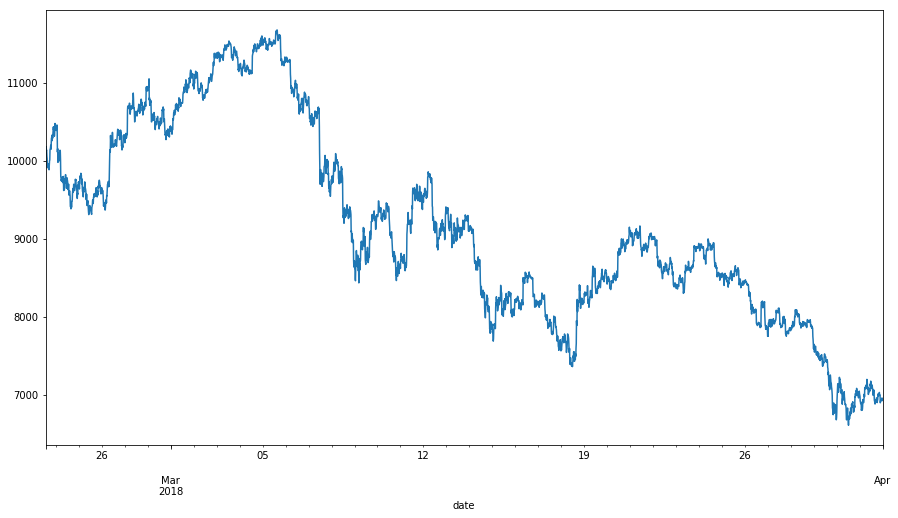

In [112]:
w["close"].plot()